In [1]:
#full download
import pandas as pd
import numpy as np
import datetime as dt
import sys
import pyodbc
import time

import myfunctions as myf
import qadconnect34plus as q

%pylab inline

sys.path.append('S:/Stoxx/Product Development and Research/Python')

esgloc ='S:/Stoxx/Product Development and Research/Projects/2399 iSTOXX MUTB Japan and Global Quality ESG/'
histloc = esgloc + '03 History/'
calcloc = histloc + '01_calc_steps/'
esgloc = histloc + '02_esg/'

Populating the interactive namespace from numpy and matplotlib


In [21]:
from stoxx.calculator import composition_zh as c
from stoxx.dates import keydates as kd

dfdts = kd.reviewdates()
dfdts['effdt']=pd.to_datetime(dfdts['effdt'], format='%d.%m.%Y', dayfirst=True)
dfdts.loc[0,'effdt']
#datetime.date(year, month, day)

Timestamp('2000-03-20 00:00:00')

In [6]:
#getting GL 1800 compositions and adtv

import requests
import io
import json

idxsym = 'sxw1'
qadits1 = 'wspit_3995_a;q;s_12,wspit_3255_a;q;s_12,wspit_5255,wspit_5145,wspit_9402,Vol_60m_LOCAL_m'
#qadits = 'DY_12m_Exclude_Gross' #ADTV_12m_EUR; 'wspit_3995_a;q;s_12'

time1=time.time()

cal = 'stxws2'
qadits = 'ADTV_3m_USD'
dt = '2009-12-01'
cur = 'USD'

#csv api
apisql = 'http://zurix06.bat.ci.dom/sidwebapi/api/Index?indexSymbol=%s&calendarName=%s&qadItems=%s&startDate=%s&target_currencies=%s&flag=Y'

#json API
#apisql = 'http://zurix06.bat.ci.dom/sidwebapi/api/Index?indexSymbol=%s&calendarName=%s&qadItems=%s&startDate=%s&target_currencies=%s'

apisql = apisql % (idxsym, cal, qadits, dt, cur)

#r=requests.get("http://mpzhwstxop01/sidwebapi/api/Index?indexSymbol=sx5e&calendarName=stxsq1&qadItems=ws_1551_q,ws_1505_q&startDate=2016-01-01&target_currencies=USD&flag=Y")
r =requests.get(apisql)
csvdata = pd.read_csv(io.StringIO(r.content.decode('utf-8')), sep=';')
#data = json.loads(r.text)
#data
#print("Received from SID {n} rows.".format(n=csvdata.size))

time2=time.time()
print('time elapsed:', (time2-time1)/60, 'minutes')
csvdata.to_csv(calcloc + '02_global1800_.csv',sep=';',index=False)

csvdata.head(3)

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

In [29]:
#global 1800
df_ = pd.read_csv(histloc +'SXW1_export.csv', sep=';')#, dtype={'symbol': object})
df_['ffmcap_eur'] = df_['free_float_value'] * df_['out_no_shares'] * df_['price_in_local'] * df_['FX_local_to_Index_Currency']

dfind = pd.read_excel(histloc + 'industry_codes1.xlsx', sheetname='full')
dfind['old_subs'] = dfind['old_subs'].astype(int)
df_ = pd.merge(df_, dfind, how='left', left_on='icb_subsector', right_on='old_subs')

del df_['old_subs']

ct = 0
for c in df_.columns:
    #print(ct, c)
    ct+=1

df = df_[[1,7,12,21,8,11,24,6,5,25,26,27,23]].copy()
df.columns = ['date','isin','curr','fx','sedol','icb','ffmcap_eur','name','symbol','ICB_ind','ICB_sec','ICB_ind_name','ADTV_3M_USD']

df.to_csv(calcloc + '02_global1800.csv',sep=';',index=False)
do_step4('02_global1800')

2799
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
done step4


In [8]:
df_ = pd.read_csv(calcloc +'02_jp600.csv', sep=';', dtype={'symbol': object})
ct = 0
for c in df_.columns:
    print(ct, c)
    ct+=1

0 date
1 isin
2 curr
3 fx
4 sedol
5 icb
6 ffmcap_eur
7 name
8 symbol
9 dt
10 ICB_ind
11 ICB_sec
12 ICB_ind_name


In [33]:
#c.get_composition('sx60jp', dfdts.loc[0,'effdt'], 'open')

##prepare input universe
#do_step1()
do_step2()
do_step3()
do_step4('02_jp600')
print('done all')

done step2


C:\Users\iv822\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\iv822\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


done step3


C:\Users\iv822\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


1065
200
400
600
800
1000
done step4
done all


In [25]:
#use IF compositions
def do_step1():
    cut_dates = ['2010-08-02','2012-03-13'] #launch dates are '2011-02-21','2012-04-16', but these here are the cut dates for production available data

    fs = ['IF_STXJPTM_EUR_Price.csv','IF_STXJP600_EUR_Price.csv']
    ct=0
    for f in fs:
        dfjp = pd.read_csv(histloc + f, sep=';', 
                       usecols=['Date','ISIN','SEDOL','Currency','ICB Subsector','F/X rate','Freefloat Market Cap'],
                          dtype={'SEDOL': object, 'ICB Subsector': object, 'Freefloat Market Cap': float}).sort_values('Date', ascending=True)
        dfjp['name'] = ''
        dfjp['symbol'] = ''
        dfjp['dt'] = pd.to_datetime(dfjp['Date'], format='%Y-%m-%d', dayfirst=True)

        dfjp = dfjp[dfjp['Date'] < cut_dates[ct]].reset_index(drop=True) ##### only for last rebalancing

        dfjp = dfjp.rename(columns={'Date':'date', 'ISIN':'isin', 'SEDOL':'sedol', 'Currency':'curr', 'ICB Subsector': 'icb',
                                    'F/X rate':'fx', 'Freefloat Market Cap': 'ffmcap_eur'})

        #updating missing sedols - need sedols to get Worldscope data
        dfjp.loc[dfjp['isin']=='JP3480400005','sedol']='6569668' #update sedol for Cedyna Financial - delisted comp
        dfjp.loc[dfjp['isin']=='JP3633000009','sedol']='6900621'
        dfjp.loc[dfjp['isin']=='JP3700000007','sedol']='6641124' #NIPPON LIGHT METAL
        
        for index, row in dfjp[dfjp.sedol.isnull()].iterrows(): #update rest using QAD sedols
            if not np.isnan(q.get_infocode(row['isin'])):
                dfjp.loc[index,'sedol']=q.get_sedol(q.get_infocode(row['isin']))
        if ct==0:
            dfjp.to_csv(calcloc + '01_STXJPTMI_Base_4Q.csv',sep=';',index=False)
            dfy = dfjp
        else:
            dfjp = dfjp[dfjp['dt'].map(lambda x: x.month==6 or x.month==12)]
            dfjp.to_csv(calcloc + '01_STXJP600_Base.csv',sep=';',index=False)
            dfz = dfjp
        ct=ct+1

    print('done step1')

In [30]:
#get the composition from production
from stoxx.dates import keydates as kd

def do_step2():

    cut_dates = ['2012-03-13', '2010-08-02'] #launch dates are '2011-02-21','2012-04-16'

    rev_qs = [[6,12], [3,6,9,12]]
    idxs = ['sx60jp', 'tw1p'] #tcjpp: japan TMI; use tw1p instead;  sx60jp: japan 600
    #idxs = ['sx60jp', 'xx']

    rdts = kd.reviewdates()
    rdts['effdt'] = pd.to_datetime(rdts['effdt'], format='%d.%m.%Y', dayfirst=True)
    rdts['impdt'] = pd.to_datetime(rdts['impdt'], format='%d.%m.%Y', dayfirst=True)

    locdata = 'S:/Stoxx/Stoxx_Reports/stoxx_composition_files/STOXX/'
    dffoo = pd.DataFrame()
    ct=0
    for idx in idxs:
        #print(idx, rev_qs[ct],cut_dates[ct])
        rd = rdts[rdts.mth.isin(rev_qs[ct]) & (rdts.effdt > cut_dates[ct])]['effdt']
        dfdts = pd.DataFrame(rd)

        dffoo = pd.DataFrame()

        for index, row in dfdts.iterrows():
            dt = str(row[dfdts.columns[0]])[:10].replace('-','')
            of = '/open_' + idx + '_' + dt + '.csv'

            try:    
                dffo = pd.read_csv(locdata + idx + of, encoding='utf-8-sig', sep=';', dtype={'ICB': object, 'Internal_Number': object})
                #print(1, dt, idx, len(dffo.columns))
            except:
                try:
                    dffo = pd.read_csv(locdata + idx + of, encoding='iso-8859-1', sep=';', dtype={'ICB': object, 'Internal_Number': object})
                    #print(2, dt, idx)
                except:
                    pass

            if len(dffo.columns)==37:
                del dffo['RIC']
                del dffo[dffo.columns[len(dffo.columns)-1]]
                df1 = dffo[[0,11,16,26,12,18,28,14,10]]

            if len(dffo.columns)==36:
                del dffo['RIC']
                cols = dffo.columns
                dffo.insert(0, 'x', dffo.index)
                del dffo[dffo.columns[len(dffo.columns)-1]]
                dffo.columns = cols
                df1 = dffo[[0,11,16,26,12,18,28,14,10]] 

            df1 = df1.rename(columns={'Next_Trading_Day':'date', 'ISIN':'isin', 'SEDOL':'sedol', 'Currency':'curr', 
                                    'FX_local_to_Index_Currency':'fx', 'ICB': 'icb', 'Mcap_Units_Index_Currency': 'ffmcap_eur',
                                    'Instrument_Name': 'name', 'Internal_Number':'symbol'})

            df1['dt']=pd.to_datetime(df1['date'], format='%Y-%m-%d', dayfirst=True)

            dffoo = pd.concat([dffoo, df1], axis=0)
            #print(len(dffo.columns))

        dffoo.to_csv(calcloc + '01_' + idx + '_prod.csv', index=False, sep=';')
        #dffoo['dt'] = pd.to_datetime(dffoo['Next_Trading_Day'], format='%Y-%m-%d', dayfirst=True)

        ct = ct + 1

    print('done step2')

In [31]:
#get icb mapping and full files
def do_step3():
    dfind = pd.read_excel(histloc + 'industry_codes1.xlsx', sheetname='full')
    dfind['old_subs'] = dfind['old_subs'].astype(int)

    dfjp1 = pd.read_csv(calcloc + '01_STXJP600_Base.csv', sep=';')
    dfjp2 = pd.read_csv(calcloc + '01_sx60jp_prod.csv', sep=';', dtype={'symbol': object})

    dfjp = pd.concat([dfjp1, dfjp2], axis=0).sort_values(['date', 'ffmcap_eur'], ascending=[True, False])
    dfjp.loc[dfjp['isin']=='JP3463200000', 'icb'] = 8773 #missing ICB in database
    dfjp = pd.merge(dfjp, dfind, how='left', left_on='icb', right_on='old_subs')

    del dfjp['old_subs']
    dfjp.to_csv(calcloc + '02_jp600.csv',sep=';',index=False)

    dfjp3 = pd.read_csv(calcloc + '01_STXJPTMI_Base_4Q.csv', sep=';')
    dfjp4 = pd.read_csv(calcloc + '01_tw1p_prod.csv', sep=';', encoding='iso-8859-1', dtype={'symbol': object})
    dfjp0 = pd.concat([dfjp3, dfjp4], axis=0).sort_values(['date', 'ffmcap_eur'], ascending=[True, False])
    dfjp0.loc[dfjp0['isin']=='JP3463200000', 'icb'] = 8773 #missing ICB in database
    dfjp0 = pd.merge(dfjp0, dfind, how='left', left_on='icb', right_on='old_subs')
    del dfjp0['old_subs']
    dfjp0.to_csv(calcloc + '02_jptmi.csv',sep=';',index=False)

    print('done step3')

In [27]:
#get all infocodes
def do_step4(f): #f: '02_jp600', '02_global1800'
    df = pd.read_csv(calcloc + f + '.csv', sep=';', dtype={'symbol': object})

    df = df.sort_values(['date', 'isin'], ascending=[True, True]).reset_index(drop=True)
    df['dt2']=pd.to_datetime(df['date'], format='%Y-%m-%d', dayfirst=True)

    dfds = pd.read_excel(histloc + 'DSCODE_map.xlsx')

    dto = np.datetime64('2050-01-01')
    dfds['dtto'] = dfds['dtto'].fillna(dto)

    df = df.iloc[:,:]

    infocode_list = []
    dfids = df[['sedol','isin']].drop_duplicates().reset_index(drop=True)
    print(len(dfids))
    for index, row in dfids.iterrows():
        if np.isnan(q.get_infocode(row.sedol)):
            infocode = q.get_infocode(dfids.loc[index,'isin'])
        else:
            infocode = q.get_infocode(row.sedol)

        infocode_list.append(infocode)
        if not (index+1) % 200:
            print(index+1)

    dfids['infocode'] = infocode_list
    df = pd.merge(df, dfids, how='left', on=['sedol','isin']).drop_duplicates()
    # -----------

    # get infocode from DSCODE_map 
    for index, row in dfds.iterrows():
        df.loc[df[(df.symbol==row.symbol) & (df.dt2>=row.dtfrom) & (df.dt2<=row.dtto)].index, 'infocode'] = row.infocode
    # -----------

    del df['dt2']
    try:
        del df['dt']
    except:
        pass

    df.to_csv(calcloc + f + '_info.csv', sep=';', index=False)

    print('done step4')

In [30]:
#data download - wspit

import datetime as dt

#dfin = pd.read_csv(calcloc +'02_jp600_info.csv', sep=';')
dfin = pd.read_csv(calcloc +'02_global1800_info.csv', sep=';')

#del dfin['dt']
dfin = dfin[dfin.date>='2009-12-01'].sort_values(['date','isin'], ascending=[True, True]).reset_index(drop=True)
dfin['date'] = pd.to_datetime(dfin['date'], format='%Y-%m-%d', dayfirst=True)
#df.groupby('date').count()

#small sample for test
#dfin = dfin.iloc[-10:,:]
#dfin = dfin[(dfin.date=='2004-12-20') & (dfin.sedol=='6259011')]

time1=time.time()

#delete reits
icb_reit = ['8671','8672','8673','8674','8675','8676','8677','8737','8733',8671,8672,8673,8674,8675,8676,8677,8737,8733,'REA']
dfin = dfin[-dfin.icb.isin(list(icb_reit))]

dfin['sedol_map'] = dfin['sedol'].map(lambda x: x[:6])

#dfin = dfin[['date','sedol','sedol_map']][:] #### reduce for testing

def get_sqlstr(sedlst):
    sedstr = ''
    for s in sedlst:
        sedstr = sedstr + s[:6] + ","
    return sedstr[:-1].replace("'","")

items_agg = ['1551','1505']
items_last = ['3995','3255','2999','2501','2101','2051','4860']

df2 = pd.DataFrame()

print(len(dfin))
ct=0
print(len(dfin['date'].drop_duplicates()))
for d in sorted(dfin['date'].drop_duplicates().reset_index(drop=True)):

    sedlst =list(dfin[dfin.date==d]['sedol'])
    sedstr = get_sqlstr(sedlst)
    cd =d-dt.timedelta(days=(d.day)) #cut off date
    
    df1 = dfin[dfin.date==d][['date','sedol','sedol_map']].reset_index(drop=True)
    
    for m in range(0,5):
        #print(m)
        for i_a in items_agg:
            #print(i_a)
            dat = str(myf.add_months(cd,-m*12))[:]
            #print(dat)
            dffund = q.get_prod_wswspit(i_a, sedstr, dat, 'N','wspit', -14)[['sedol','value']]
            dffund['value'] = dffund['value']
            dffund = dffund.rename(columns={'sedol':'sedol_map','value':i_a + '-'+str(m)})
            if len(dffund)==0:
                print(dat, i_a + '-'+str(m), ' - zero records')
            
            df1 = pd.merge(df1, dffund, on='sedol_map', how='left')
    
    dat = str(cd)[:10]
    for i_lst in items_last:
        #print(i_lst, d.year)
        if i_lst=='4860':
            dffund = q.get_prod_wswspit(i_lst, sedstr, dat, 'N', 'wspit', -14)[['sedol','value','epsReportDate','itemUnits']]
        elif (i_lst=='3995') & (d.year<2005):
            #print('here')
            dffund = q.get_prod_wswspit(i_lst, sedstr, dat, 'Y', 'ws', -14)[['sedol','value','epsReportDate','itemUnits']]
        else:
            dffund = q.get_prod_wswspit(i_lst, sedstr, dat, 'Y', 'wspit', -14)[['sedol','value','epsReportDate','itemUnits']]
            dffund['value'] = dffund['value']
            
        dffund = dffund.rename(columns={'sedol':'sedol_map','value':i_lst, 'epsReportDate': i_lst + '_date','itemUnits':i_lst + '_cur'})
        
        if len(dffund)==0:
            print(dat, i_lst, ' - zero records')
            
        df1 = pd.merge(df1, dffund, on='sedol_map', how='left')
            
    if len(df2)==0:
        df2 = df1
    else:
        df2 = pd.concat([df2, df1], axis=0)
        
    #print(ct)
    ct=ct+1

time2=time.time()
print('fundamental download - time elapsed:', (time2-time1)/60, 'minutes')

del df2['sedol_map']
print(len(df2))

#df2.drop_duplicates().to_csv(calcloc + '03_jp600_wspit.csv' ,sep=';',index=False)
df2.drop_duplicates().to_csv(calcloc + '03_global1800_wspit.csv' ,sep=';',index=False)

print('drop dup', len(df2))

for m in range(0,5):
    df2['1505-'+str(m)] = df2['1505-'+str(m)].fillna(0)
    df2['NI-'+str(m)] = df2['1551-'+str(m)]-df2['1505-'+str(m)]
    del df2['1551-'+str(m)]
    del df2['1505-'+str(m)]

def nistdev(series): 
    for i in range(len(series)):
        if np.isnan(series[i]):
            series[i] = 0
    ni_h=np.array(list([series[0], series[1], series[2], series[3], series[4]]))
    if len(ni_h[ni_h!=0])>=3:
        return np.std(ni_h[ni_h!=0], ddof=1)
    else:
        return np.nan

df2['NIstdev'] = df2[['NI-0', 'NI-1', 'NI-2', 'NI-3', 'NI-4']].apply(nistdev, axis=1)

df2 = df2[[0,1,2,5,8,11,14,17,20,23,24,25,26,27,28]]e

dfin = pd.merge(dfin, df2, how='left', on=['date','sedol'])
del dfin['sedol_map']

#dfin.sort_values('date', ascending=True).to_csv(calcloc + '03_jp600_wspit_format.csv' ,sep=';',index=False)
dfin.sort_values('date', ascending=True).to_csv(calcloc + '03_global1800_wspit_format.csv' ,sep=';',index=False)

print('done')
dfin.head(3)

25937
15
fundamental download - time elapsed: 17.52422107855479 minutes
25942
drop dup 25942
done


,date,isin,curr,fx,sedol,icb,ffmcap_eur,name,symbol,ICB_ind,...,2501,2101,2051,4860,NI-0,NI-1,NI-2,NI-3,NI-4,NIstdev
0,2009-12-21,AN8068571086,USD,1.0000,2779201,573,7.504034e+10,Schlumberger Ltd.,SLB,1,...,9610.000,1967.000,6087.000,5350.388,3488.601,5630.024,4923.919,3239.789,1896.835,1469.575129
1,2009-12-21,AT0000606306,EUR,1.4277,B0704T9,8355,2.712759e+09,Raiffeisen International Bank-,B0704T,8000,...,1241.000,NaN,NaN,1389.154,276.086,1077.058,1268.526,485.734,209.400,480.880378
2,2009-12-21,AT0000612601,EUR,1.4277,B067M97,4573,1.456716e+09,Intercell AG,B067M9,4000,...,55.531,3.948,10.648,-46.666,5.039,13.306,-16.468,-28.931,-25.391,18.743307


In [ ]:
#get adtv

cur = 'USD' #adtv currency

#dfin = pd.read_csv(calcloc +'03_jp600_wspit_format.csv', sep=';')
dfin = pd.read_csv(calcloc +'03_global1800_wspit_format.csv', sep=';')

dfin = dfin[dfin.date>='2009-12-01'].sort_values(['date','isin'], ascending=[True, True]).reset_index(drop=True)
#dfin['date'] = pd.to_datetime(dfin['date'], format='%Y-%m-%d', dayfirst=True)

f='SXW1E' #'SX60JP'
url='http://www.stoxx.com/download/historical_data/h_'+f.lower()+'.txt'
#print(url)
dfweb = myf.get_h([f], histloc, usedates=True)
dfweb['Date']=pd.to_datetime(dfweb['Date'], format='%d.%m.%Y', dayfirst=True)
dfweb = dfweb[-dfweb[f].isnull()].sort_values('Date', ascending=True).reset_index(drop=True)

time1=time.time()

wst=[]
wslist=['adtv', # 0
        'ctdays', # 1
        'sedol', # 2
        'date'] # 3
ct=0
#for sed in (dfin.iloc[-10:,:]['sedol']).drop_duplicates().reset_index(drop=True):
print(len(dfin))
for sed in (dfin['sedol']).drop_duplicates().reset_index(drop=True):
    
    #print(sed)
    
    dfsed = dfin[dfin.sedol==sed].reset_index(drop=True)
    wsdata = [[0 for x in range(len(wslist))] for x in range(len(dfsed))]
    #cur = dfsed.loc[0, 'curr']
    
    for index, row in dfsed.iterrows():
        
        #d=pd.to_datetime(row.date, format='%Y-%m-%d', dayfirst=True)
        d=dt.datetime.strptime(row.date, '%Y-%m-%d')
        #print(d)
        d=d-dt.timedelta(days=(d.day))
        d1=d + dt.timedelta(days=1) #first day of the month - needed for adtv calc

        
        #adtv import and calculation
        if not np.isnan(row.infocode):
            adtv_= q.get_adtv_prim_plus(row.sedol, d, myf.add_months(d,-13), cur, int(row.infocode))
        else:
            adtv_= q.get_adtv_prim_plus(row.sedol, d, myf.add_months(d,-13), cur)
        dfctdays = dfweb[(dfweb['Date']<=d) & (dfweb['Date']>=myf.add_months(d1,-3))].sort_values('Date', ascending=False).reset_index(drop=True)
        
        
        if len(adtv_)==0:
            wsdata[index][0] = 0
        else: 
            adtv_=adtv_[-adtv_.close_.isnull()].sort_values('marketdate', ascending=False).reset_index(drop=True)
            
            if len(dfctdays)>0:
                dfadtv=pd.merge(dfctdays, adtv_, how='left', left_on='Date', right_on='marketdate').iloc[:,[0,3,4]] #left join to get sxjp600 days, even if zero value
                wsdata[index][0] = (dfadtv.loc[:,'close_'] * dfadtv.loc[:,'volume']).sum() / len(dfctdays)
                wsdata[index][1] = len(dfctdays)
            else:
                wsdata[index][0] = 0
                wsdata[index][1] = 0

        wsdata[index][2] = sed
        wsdata[index][3] = row.date
        
        if ct==0:
            wsdataall = pd.DataFrame(wsdata, columns=wslist)
        else:
            wsdataall = pd.concat([wsdataall, pd.DataFrame(wsdata, columns=wslist)], axis=0)
        
        if not (ct+1) % 500:
            print(' -- ', ct+1, ' -- ')
        
        ct=ct+1

del wsdataall['ctdays']

dfin = pd.merge(dfin, wsdataall, how='left', left_on=['date','sedol'], right_on=['date','sedol']).sort_values(['date','isin'], ascending=[True, True]).drop_duplicates()        

time2=time.time()
print('time elapsed:', (time2-time1)/60, 'minutes')

#dfin.to_csv(calcloc + '04_jp600_data.csv' ,sep=';',index=False)
dfin.to_csv(calcloc + '04_global1800_data.csv' ,sep=';',index=False)


http://www.stoxx.com/download/historical_data/h_sxw1e.txt
25942


In [39]:
f = 4680 # Net income
s = 'B1G185' 
d = '2013-05-31'
final = 'N'

q.get_prod_wswspit(f, s, d, final, 'wspit', -24)

,sedol,sedol7,isin,dj_id,name,code,currencyOfDocument,epsReportDate,fiscalPeriodEndDate,value,year_,freq,item,seq,periodUpdateFlag,itemUnits,latest_value


(array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.]),
 <a list of 8 Text xticklabel objects>)

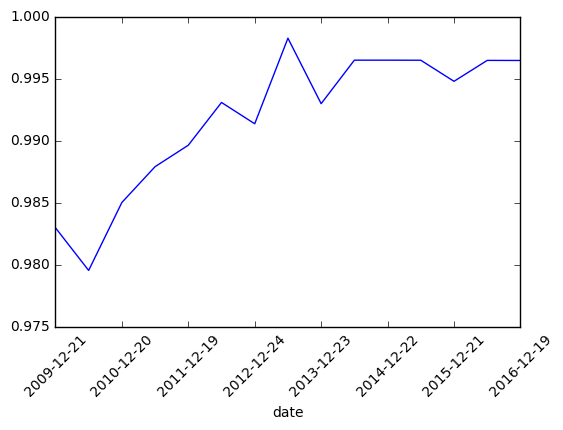

In [51]:
#coverage
fld = 'NI-0' # 'NI-0' 4860
df = pd.read_csv(calcloc +'03_jp600_wspit_format.csv', sep=';')
a = df[-(df[fld].isnull())].groupby('date').count()['sedol']
b = df.groupby('date').count()['sedol']
(a/b).plot()
plt.xticks(rotation=45)

(array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.]),
 <a list of 8 Text xticklabel objects>)

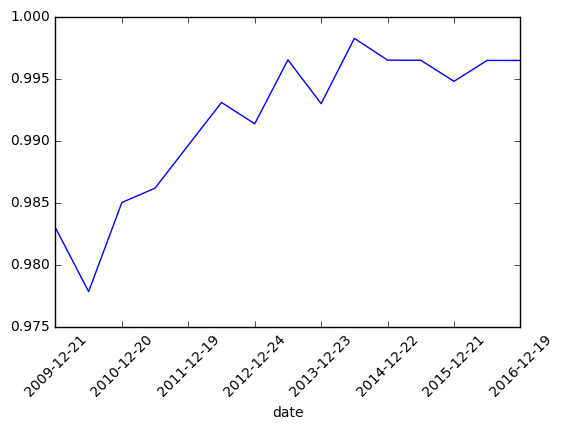

In [64]:
#coverage
fld = '4860' # 'NI-0' 4860
df = pd.read_csv(calcloc +'03_jp600_wspit_format.csv', sep=';')
a = df[-(df[fld].isnull())].groupby('date').count()['sedol']
b = df.groupby('date').count()['sedol']
(a/b).plot()
plt.xticks(rotation=45)

In [47]:
f = 4860 # Net income
s = 'B89C2N' 
d = '2013-05-31'
final = 'N'

q.get_prod_wswspit(f, s, d, final, 'wspit', -14)

,sedol,sedol7,isin,dj_id,name,code,currencyOfDocument,epsReportDate,fiscalPeriodEndDate,value,year_,freq,item,seq,periodUpdateFlag,itemUnits,latest_value
0,B89C2N,None,None,None,NISSHIN STEEL CO L NPV,86631,None,2013-04-24,2012-03-31,42075.0,2012,A,4860,1,None,JPY,1


In [43]:
sedol6 = 'B89C2N'
item = 4860

x = q.get_wspit_data(sedol6, item)
x[(x.PointDate<='2013-05-31')].head(10)# & (x.FreqCode==1)]

,Code,PointDate,FreqCode,FiscalPrd,Item,Value_,CalPrdEndDate
1,86631,2013-04-24,1,2012,4860,42075.0,2012-03-31
0,86631,2013-04-24,1,2011,4860,24426.0,2011-03-31


In [ ]:
#get esg data
import scipy.stats as stats

dfjp = pd.read_csv(calcloc + '04_jp600_data.csv' ,sep=';', dtype={'sedol': str})

dfjp = dfjp[dfjp.date<='2016-10-01'].reset_index(drop=True) #temporly, before getting 201611 data

id_incidents=np.array([0,55,97,109,151,187,229,277,352,388,442])

id_management=np.array([0,3,10,16,37,58,66,69,70,76,79,85,88,91,94,100,112,115,118,121,127,145,
                        148,154,157,163,169,226,232,235,238,280,286,301,307,310,316,319,322,325,
                        328,331,334,340,343,346,349,355,358,361,406])

dfesg1 = pd.DataFrame(); dfesg2 = pd.DataFrame()
dfjp['map'] = ''
for dat in dfjp.date.drop_duplicates():

    d = dt.datetime.strptime(dat, '%Y-%m-%d')
    dprev = d-dt.timedelta(days=(d.day+1))
    yr = str(dprev.year)
    mth = str(dprev.month)
    if len(mth)==1:
        mth = '0' + mth
    dfjp.loc[dfjp[dfjp.date==dat].index, 'map'] = yr + mth
    
    dfesg = pd.read_excel(esgloc + yr + mth + '_Japan.xlsx', sheetname='Sheet1')
    dfesg = dfesg.rename(columns={'SEDOL':'sedol'})
    dfesg['sedol'] = dfesg['sedol'].map(lambda x: str(x))

    dfesg1_ = dfesg[id_incidents]#.dropna().reset_index(drop=True)
    dfesg1_['map'] = yr + mth
    dfesg1 = pd.concat([dfesg1, dfesg1_], axis=0)

    dfesg2_ = dfesg[id_management]
    dfesg2_['map'] = yr + mth
    dfesg2 = pd.concat([dfesg2, dfesg2_], axis=0)

col_incidents = dfesg[id_incidents[1:]].columns
col_management = dfesg[id_management[1:]].columns
dfjp = pd.merge(dfjp, dfesg1, how='left', on= ['sedol','map'])
dfjp = pd.merge(dfjp, dfesg2, how='left', on= ['sedol','map'])
#dfesg2.to_csv(calcloc + '99_esg2_.csv' ,sep=';',index=False)
#dfesg1.to_csv(calcloc + '99_esg1_.csv' ,sep=';',index=False)

dfjp.to_csv(calcloc + '05_jp600_data_esg.csv' ,sep=';',index=False)
print('done')

In [5]:
dfesg = pd.read_excel(esgloc + '201605_Japan.xlsx', sheetname='Sheet1')
id_incidents=np.array([0,55,97,109,151,187,229,277,352,388,442])
id_management=np.array([0,3,10,16,37,58,66,69,70,76,79,85,88,91,94,100,112,115,118,121,127,145,
                        148,154,157,163,169,226,232,235,238,280,286,301,307,310,316,319,322,325,
                        328,331,334,340,343,346,349,355,358,361,406])

col_incidents = dfesg[id_incidents[1:]].columns
col_management = dfesg[id_management[2:]].columns

#print(col_management)
for c in col_incidents:
    print(c)

G105000-Score
G213000-Score
G304000-Score
S107000-Score
S203000-Score
S303000-Score
S403000-Score
E112000-Score
E202000-Score
E302000-Score


In [62]:
#selection ESG

import scipy.stats as stats

##get the esg column tags
id_incidents=np.array([0,55,97,109,151,187,229,277,352,388,442])
id_management=np.array([0,3,10,16,37,58,66,69,70,76,79,85,88,91,94,100,112,115,118,121,127,145,
                        148,154,157,163,169,226,232,235,238,280,286,301,307,310,316,319,322,325,
                        328,331,334,340,343,346,349,355,358,361,406])

dfesg = pd.read_excel(esgloc + '201605_Japan.xlsx', sheetname='Sheet1')
col_incidents = dfesg[id_incidents[1:]].columns
col_management = dfesg[id_management[2:]].columns
##

dfjp = pd.read_csv(calcloc + '05_jp600_data_esg.csv' ,sep=';')

dfjp[['2501','2101','2051']].fillna(0, inplace=True)
dfjp['ROE'] = dfjp['NI-0'] / dfjp['3995']
dfjp['Cap2Asset'] = dfjp['3255'] / (dfjp['3995'] + dfjp['3255'])
dfjp['CFGenInd'] = dfjp.loc[dfjp[dfjp['ICB_ind']!=8000].index, '4860'] / (dfjp['2501'] + dfjp['2101'] + dfjp['2051'])
dfjp.loc[dfjp[dfjp['ICB_ind']==8000].index,'CFGenFin'] = dfjp.loc[dfjp[dfjp['ICB_ind']==8000].index, '4860'] / dfjp['2999']
dfjp['Stability'] = dfjp['NIstdev'] / dfjp['3995']

#ESG1 score
def f1(series):
    inc_sum = series[0] + series[1] + series[2] + series[3] + series[4] + series[5] + series[6] + series[7] + series[8] + series[9]
    inc_ct = len(series[-series.isnull()])
    return inc_sum / inc_ct
elig_idx = dfjp[-dfjp.peer_group.isnull()].index
dfjp.loc[elig_idx,'ESG1'] = dfjp.loc[elig_idx, list(col_incidents)].apply(f1, axis=1)
    
    
dfjp['ROE_missing'] = 'ok'
dfjp.loc[dfjp[(dfjp['3995']<0) | (dfjp['NI-0']<0)].index,'ROE_missing'] = 'missing'

dfjp['C2A_missing'] = 'ok'
dfjp.loc[dfjp[(dfjp['3995']<0)].index,'C2A_missing'] = 'missing'

#calculate ranking for scoring - using mcap as a second ranking criterion
for d in dfjp.sort_values('date', ascending=True)['date'].drop_duplicates():
    dfidx1 = dfjp[dfjp.date==d].sort_values(['adtv','ffmcap_eur'], ascending=[False, False])[['adtv','ffmcap_eur']].index
    rk1 = np.arange(len(dfjp[dfjp.date==d])-1, -1, -1)
    dfjp.loc[dfidx1, 'rkadtv'] = rk1
    dfjp.loc[dfidx1, 'rkadtv'] = dfjp.loc[dfidx1, 'rkadtv'].map(lambda x: stats.percentileofscore(rk1, x, kind='rank')/100.)

    dfidx2 = dfjp[(dfjp.date==d) & (dfjp.ROE_missing=='ok')].sort_values(['ROE','ffmcap_eur'], ascending=[False, False])[['ROE','ffmcap_eur']].index
    rk2 = np.arange(len(dfjp[(dfjp.date==d) & (dfjp.ROE_missing=='ok')])-1, -1, -1)
    dfjp.loc[dfidx2, 'rkROE'] = rk2
    dfjp.loc[dfidx2, 'rkROE'] = dfjp.loc[dfidx2, 'rkROE'].map(lambda x: stats.percentileofscore(rk2, x, kind='rank')/100.)

    dfidx3 = dfjp[(dfjp.date==d) & (dfjp.C2A_missing=='ok')].sort_values(['Cap2Asset','ffmcap_eur'], ascending=[True, False])[['Cap2Asset','ffmcap_eur']].index
    rk3 = np.arange(len(dfjp[(dfjp.date==d) & (dfjp.C2A_missing=='ok')])-1, -1, -1)
    dfjp.loc[dfidx3, 'rkC2A'] = rk3
    dfjp.loc[dfidx3, 'rkC2A'] = dfjp.loc[dfidx3, 'rkC2A'].map(lambda x: stats.percentileofscore(rk3, x, kind='rank')/100.)
    
    dfidx4_1 = dfjp[(dfjp.date==d) & (-dfjp.CFGenInd.isnull())].sort_values(['CFGenInd','ffmcap_eur'], ascending=[False, False])[['CFGenInd','ffmcap_eur']].index
    dfidx4_2 = dfjp[(dfjp.date==d) & (-dfjp.CFGenFin.isnull())].sort_values(['CFGenFin','ffmcap_eur'], ascending=[False, False])[['CFGenFin','ffmcap_eur']].index
    rk4_1 = np.arange(len(dfjp[(dfjp.date==d) & (-dfjp.CFGenInd.isnull())])-1, -1, -1)
    rk4_2 = np.arange(len(dfjp[(dfjp.date==d) & (-dfjp.CFGenFin.isnull())])-1, -1, -1)
    dfjp.loc[dfidx4_1, 'rkS_1'] = rk4_1
    dfjp.loc[dfidx4_1, 'rkS_1'] = dfjp.loc[dfidx4_1, 'rkS_1'].map(lambda x: stats.percentileofscore(rk4_1, x, kind='rank')/100.)
    dfjp.loc[dfidx4_2, 'rkS_2'] = rk4_2
    dfjp.loc[dfidx4_2, 'rkS_2'] = dfjp.loc[dfidx4_2, 'rkS_2'].map(lambda x: stats.percentileofscore(rk4_2, x, kind='rank')/100.)
    bothix = dfidx4_1.append(dfidx4_2)
    dfjp.loc[bothix, ['rkS_1', 'rkS_2']] = dfjp.loc[bothix, ['rkS_1', 'rkS_2']].fillna(0)
    
    dfidx5 = dfjp[dfjp.date==d].sort_values(['Stability','ffmcap_eur'], ascending=[True, False])[['Stability','ffmcap_eur']].index
    rk5 = np.arange(len(dfjp[dfjp.date==d])-1, -1, -1)
    dfjp.loc[dfidx5, 'rkStabil'] = rk5
    dfjp.loc[dfidx5, 'rkStabil'] = dfjp.loc[dfidx5, 'rkStabil'].map(lambda x: stats.percentileofscore(rk5, x, kind='rank')/100.)
    
    dfidx6 = dfjp[(-dfjp.peer_group.isnull()) & (dfjp.date==d)].sort_values(['ESG1','ffmcap_eur'], ascending=[False, False])[['ESG1','ffmcap_eur']].index
    rk6 = np.arange(len(dfjp[(-dfjp.peer_group.isnull()) & (dfjp.date==d)])-1, -1, -1)    
    dfjp.loc[dfidx6, 'scree_ESG1'] = rk6
    dfjp.loc[dfidx6, 'scree_ESG1'] = dfjp.loc[dfidx6, 'scree_ESG1'].map(lambda x: stats.percentileofscore(rk6, x, kind='rank')/100.)
    
    #ESG2 score - col_management
    for pg in dfjp[(dfjp.date==d) & (-dfjp.peer_group.isnull())]['peer_group'].drop_duplicates():
        idx_scores = (dfjp[(dfjp.date==d) & (dfjp.peer_group==pg)]).index
        item_scores = dfjp.loc[idx_scores, col_management]
        avg_pg = [mean(x[(x>=0) | (x<0)]) for x in np.array(item_scores).T] #average per peer_group
        dfjp.loc[idx_scores, 'ESG2_pre'] = [mean(y[(y>=0) | (y<0)]) for y in np.array(item_scores-avg_pg)]
        
    dfidx7 = dfjp[(-dfjp.peer_group.isnull()) & (dfjp.date==d)].sort_values(['ESG2_pre','ffmcap_eur'], ascending=[False, False])[['ESG2_pre','ffmcap_eur']].index
    rk7 = np.arange(len(dfjp[(-dfjp.peer_group.isnull()) & (dfjp.date==d)])-1, -1, -1)    
    dfjp.loc[dfidx7, 'rkESG2'] = rk7
    dfjp.loc[dfidx7, 'rkESG2'] = dfjp.loc[dfidx7, 'rkESG2'].map(lambda x: stats.percentileofscore(rk7, x, kind='rank')/100.)
       
dfjp['scree_ESG1'] = dfjp['scree_ESG1'].fillna(0.5)
    
dfjp['ESG2'] = dfjp['rkESG2'].map(lambda x: max(0, x-0.5)) * 2
dfjp['ESG2'] = dfjp['ESG2'].fillna(0)

dfjp['rkCFGen'] = dfjp['rkS_1'] + dfjp['rkS_2']
del dfjp['rkS_1']
del dfjp['rkS_2']

#calculate ranking for screening (rank the rank)
scree_criteria =['adtv', 'ROE', 'C2A', 'CFGen', 'Stabil']
for sc in scree_criteria:
    dfjp['scree_'+sc] = -1
    
for d in dfjp.sort_values('date', ascending=True)['date'].drop_duplicates():
    for sc in scree_criteria:
        dfidx = dfjp[dfjp.date==d].sort_values(['rk'+sc,'ffmcap_eur'], ascending=[False, False])[['rk'+sc,'ffmcap_eur']].index
        rk = np.arange(len(dfjp[dfjp.date==d])-1, -1, -1)
        dfjp.loc[dfidx, 'scree_'+sc] = rk
        dfjp.loc[dfidx, 'scree_'+sc] = dfjp.loc[dfidx, 'scree_'+sc].map(lambda x: stats.percentileofscore(rk, x, kind='rank')/100.)

dfjp['factor_screen'] = ''
idxout = dfjp[(dfjp.scree_ROE<0.2) | (dfjp.scree_C2A<0.05) | (dfjp.scree_CFGen<0.05) | 
              (dfjp.scree_Stabil<0.05) | (dfjp.scree_ESG1<0.1)].index
dfjp.loc[idxout, 'factor_screen'] = 'out'

dfjp['final_score'] = ''
idxin = dfjp[dfjp['factor_screen']!='out'].index
dfjp.loc[idxin, 'final_score'] = dfjp['rkROE']*0.4 + ((dfjp['rkC2A'] + dfjp['rkCFGen'] 
                                                       + dfjp['rkStabil'])*0.4/3) + dfjp['ESG2']*0.2

#component selection
dfjp['old'] = False
dfjp['rkFinal'] = np.nan
dfjp['new'] = False
ct=0
for d in dfjp.sort_values('date', ascending=True)['date'].drop_duplicates():
    ct=ct+1
    if ct==1:
        dfjp.loc[dfjp[dfjp.date==d].index,'old'] = False
    else:
        #mark the current components
        dfnew = dfjp[(dfjp.date==d)][['infocode']] #take all current candidates
        dfnew = pd.merge(dfnew, dfold, how='left', on='infocode') #link old (column new)
        dfnew['new'] = dfnew['new'].fillna(False)
        listold = dfnew['new'].tolist()
        dfjp.loc[dfjp[dfjp.date==d].index,'old'] = listold

    index2del = dfjp[(dfjp.date==d) & (dfjp.old==False) & (dfjp.rkadtv<0.2)].index

    rkFinal = dfjp[(dfjp.date==d) & -(dfjp.index.isin(index2del)) & (dfjp.final_score!='') & -(dfjp.final_score.isnull())]['final_score'].rank(ascending=0)
    dfjp.loc[rkFinal.index,'rkFinal'] = rkFinal
    #For current components of the index, if its Quality score is more than 95% of the Quality score 
    #of the 200th stock, then it will remain in the index
    try:
        qualitybuffer = dfjp[(dfjp.date==d) & (dfjp['rkFinal']==200)].reset_index(drop=True).loc[0,'final_score'] * 0.95    
    except:
        qualitybuffer = 0

    ix1 = dfjp.loc[rkFinal.index,:].index[dfjp.loc[rkFinal.index,'final_score']>qualitybuffer]
    ix2 = dfjp[(dfjp.date==d) & (dfjp.old==True)].index
    dfjp.loc[ix1.intersection(ix2),'new'] = True
    
    count200 = 200 - (dfjp[(dfjp.date==d) & (dfjp.new==True)].count()['isin'])
    idxcount200 = (dfjp[(dfjp.date==d) & (dfjp['new']==False)].sort_values('rkFinal', ascending=True)['new'].head(count200)).index
    dfjp.loc[idxcount200, 'new'] = True
    numcomp = dfjp.loc[(dfjp.date==d) & (dfjp.new==True)].count()['isin']
    print(d, '-', count200, '-', numcomp)
    
    dfold = dfjp[(dfjp.date==d) & (dfjp.new==True)][['infocode','new']]

dfjp.sort_values(['date','rkFinal'], ascending=[True,True]).to_csv(calcloc + '06_jp_quality_esg_sel_list.csv' ,sep=';',index=False)

#checked

dfjp['ffmcap_jpy'] = dfjp['ffmcap_eur'] / dfjp['fx']
dfjp = dfjp[dfjp.new==True][[0,1,2,3,4,5,7,8,9,10,11,6,115,38,111,113]].sort_values(['date','ffmcap_eur'], ascending=[True,False])
dfjp.reset_index(inplace=True, drop=True)

dfjp['wgt']=0
dfjp['cap']=0.02
dfjp['capfactor']=0
dfjp['cappedwgt']=0
sumcap = dfjp.groupby('date').sum()['ffmcap_jpy']
ctcomps = dfjp.groupby('date').count()['symbol']

for i in range(len(sumcap)):
    wgt = dfjp.loc[dfjp[dfjp.date==sumcap.index[i]].index, 'ffmcap_jpy'] / sumcap[i]
    dfjp.loc[wgt.index,'wgt'] = wgt
    #dfjp.loc[wgt.index,'wgt'] = 100./ctcomps[i] # weight equal weighted (comment out) ***********************
    dfftrs = myf.calccapfacs(dfjp.loc[dfjp[dfjp.date==sumcap.index[i]].index,['wgt','cap']])
    dfftrs.index = dfjp[dfjp.date==sumcap.index[i]].index #reindex the capfactor df so corresponds to the target df indices
    dfjp.loc[wgt.index,'capfactor'] = dfftrs['capfactor']
    dfjp.loc[wgt.index,'cappedwgt'] = dfftrs['cappedwgt']

dfjp.to_csv(calcloc + '07_jp_quality_esg_wgts.csv', sep=';',index=False)

print('weighting done')

#index factory files
dfjp['cusip'] = np.nan
for z in ['ISMJSUP', 'ISMJSUN', 'ISMJSUG']:
    for d in dfjp.sort_values('date', ascending=True)['date'].drop_duplicates():
        dfif = dfjp[(dfjp.date==d)][['sedol','cusip','isin','cappedwgt']]
        dfif.columns = ['SEDOL<string>','CUSIP<string>','ISIN<string>','Weight']
        #dfif.to_csv(histloc + '03 index factory/ISMJSU/' + z + '_' + str(d).replace('-','') + '.csv', float_format='%.9f',index=False)    
    #print('index factory files for ' + z + ' generated')
    
print('done')

C:\Users\iv822\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\frame.py:2762: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\iv822\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Users\iv822\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:140: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.


2009-12-21 - 200 - 200
2010-06-21 - 45 - 200
2010-12-20 - 47 - 200
2011-06-20 - 38 - 200
2011-12-19 - 27 - 200
2012-06-18 - 29 - 200
2012-12-24 - 27 - 200
2013-06-24 - 29 - 200
2013-12-23 - 31 - 200
2014-06-23 - 35 - 200
2014-12-22 - 25 - 200
2015-06-22 - 35 - 200
2015-12-21 - 34 - 200
2016-06-20 - 20 - 200


C:\Users\iv822\Documents\Python Scripts\myfunctions.py:879: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df_comp = df_comp.sort(df_comp.columns[0],ascending=False)


weighting done
done


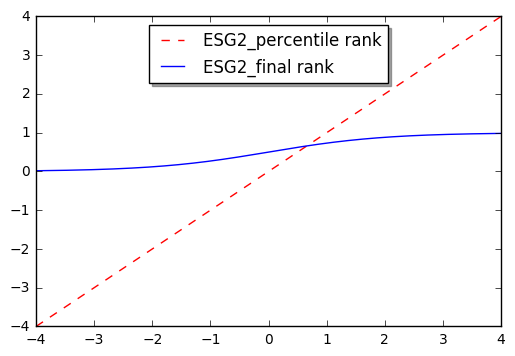

In [37]:
#graphical representaion of ESG2 function
import numpy as np
import matplotlib.pyplot as plt

t = np.arange(-4., 4.0, 0.01)

def f_(x):
    return max(0, x-0.5) * 2.

def f(x):
    return 1. / (1. + exp(-x))

vecf = np.vectorize(f)
vecf(t)

#plt.plot(t, t, 'r--', t, vecf(t), 'b-')
#plt.show()
fig, ax = plt.subplots()
ax.plot(t, t, 'r--', label='ESG2_percentile rank')
ax.plot(t, vecf(t), 'b-', label='ESG2_final rank')
legend = ax.legend(loc='upper center', shadow=True)
